<a href="https://colab.research.google.com/github/Daivar/Deep_Learning_Models/blob/main/BSDS500_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [4]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

print(data_dir)
print(root_dir)

70778880/70763455 [==============================] - 14s 0us/step
/root/.keras/datasets/BSR
/root/.keras/datasets/BSR/BSDS500/data


In [ ]:
!ls -alht /root/.keras/datasets/BSR/BSDS500/data/images/test

# !ls -alht /root/.keras/datasets/BSR/bench

In [6]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


In [7]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

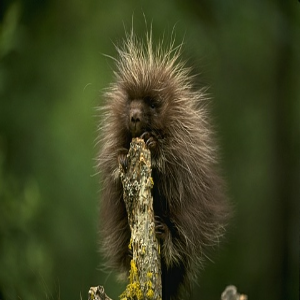

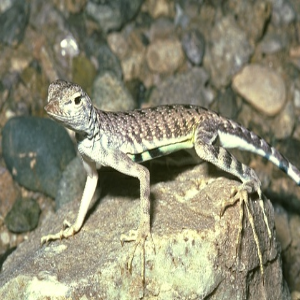

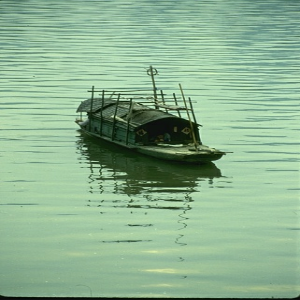

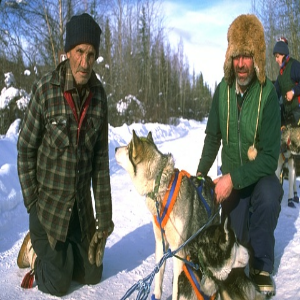

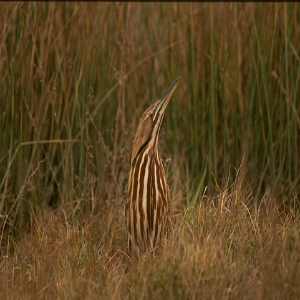

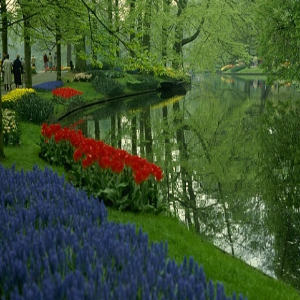

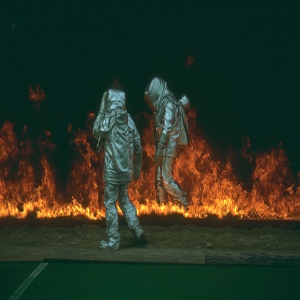

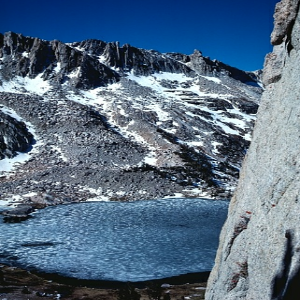

In [8]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [ ]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted([ os.path.join(test_path, fname) for fname in os.listdir(test_path) if fname.endswith(".jpg") ])
test_img_paths

In [10]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")

def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

train_ds = train_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
valid_ds = valid_ds.prefetch(buffer_size=32)

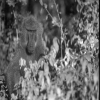

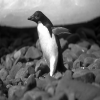

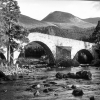

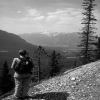

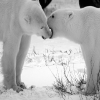

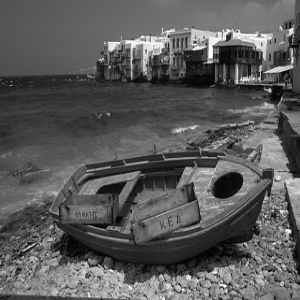

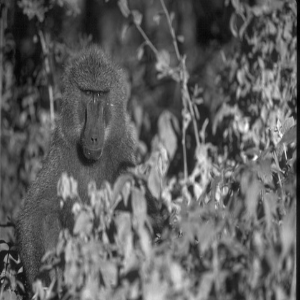

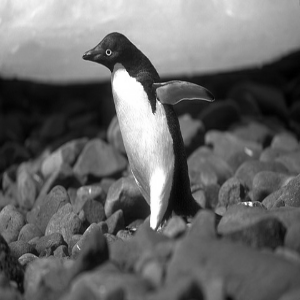

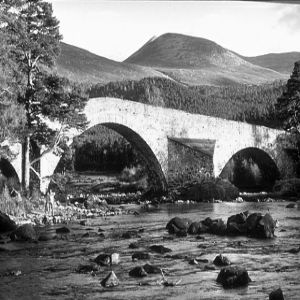

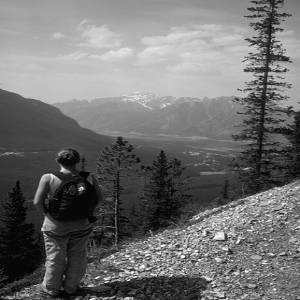

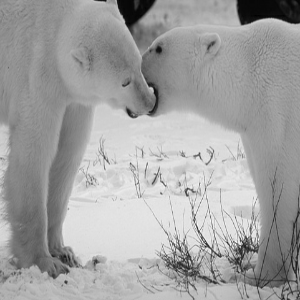

In [11]:
for batch in train_ds.take(1):
    for img in batch[0]: # train
        display(array_to_img(img))
    for img in batch[1]: # validation
        display(array_to_img(img))

In [12]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor) # https://stackoverflow.com/a/44266640/1964707

    return keras.Model(inputs, outputs)

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title, limits=(200, 300, 100, 200)):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = limits
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input) # <----- we upscale based on what the model returns
    print("Out shape: " + str(out.shape))

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    return out_img

In [15]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"])) 

In [16]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

Epoch 1/41
Mean PSNR for epoch: 26.38
Out shape: (1, 321, 480, 1)


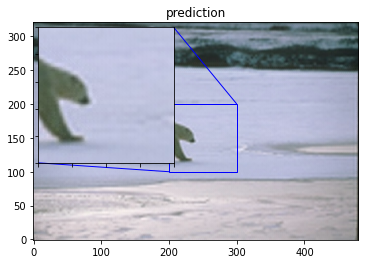

50/50 - 50s - loss: 0.0027 - val_loss: 0.0024 - 50s/epoch - 1s/step
Epoch 2/41
Mean PSNR for epoch: 26.11
50/50 - 44s - loss: 0.0028 - val_loss: 0.0024 - 44s/epoch - 873ms/step
Epoch 3/41
Mean PSNR for epoch: 26.34
50/50 - 44s - loss: 0.0027 - val_loss: 0.0024 - 44s/epoch - 877ms/step
Epoch 4/41
Mean PSNR for epoch: 26.47
50/50 - 44s - loss: 0.0027 - val_loss: 0.0024 - 44s/epoch - 875ms/step
Epoch 5/41
Mean PSNR for epoch: 26.51
50/50 - 44s - loss: 0.0027 - val_loss: 0.0024 - 44s/epoch - 875ms/step
Epoch 6/41
Mean PSNR for epoch: 26.44
50/50 - 44s - loss: 0.0027 - val_loss: 0.0024 - 44s/epoch - 874ms/step
Epoch 7/41
Mean PSNR for epoch: 25.94
50/50 - 44s - loss: 0.0026 - val_loss: 0.0024 - 44s/epoch - 874ms/step
Epoch 8/41
Mean PSNR for epoch: 26.47
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 874ms/step
Epoch 9/41
Mean PSNR for epoch: 25.62
50/50 - 44s - loss: 0.0039 - val_loss: 0.0030 - 44s/epoch - 874ms/step
Epoch 10/41
Mean PSNR for epoch: 26.59
50/50 - 44s - loss: 0

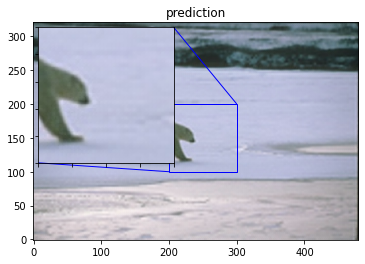

50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 889ms/step
Epoch 22/41
Mean PSNR for epoch: 26.53
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 872ms/step
Epoch 23/41
Mean PSNR for epoch: 26.94
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 872ms/step
Epoch 24/41
Mean PSNR for epoch: 26.51
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 872ms/step
Epoch 25/41
Mean PSNR for epoch: 26.71
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 872ms/step
Epoch 26/41
Mean PSNR for epoch: 26.87
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 871ms/step
Epoch 27/41
Mean PSNR for epoch: 26.60
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 872ms/step
Epoch 28/41
Mean PSNR for epoch: 26.68
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023 - 44s/epoch - 874ms/step
Epoch 29/41
Mean PSNR for epoch: 26.20
50/50 - 44s - loss: 0.0026 - val_loss: 0.0025 - 44s/epoch - 872ms/step
Epoch 30/41
Mean PSNR for epoch: 26.38
50/50 - 44

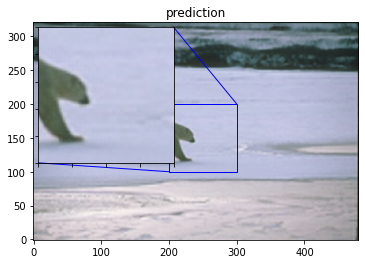

50/50 - 44s - loss: 0.0025 - val_loss: 0.0023 - 44s/epoch - 886ms/step


In [19]:
epochs = 41 #

model.compile(optimizer=optimizer, loss=loss_fn)
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Out shape: (1, 321, 480, 1)
PSNR of low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.0528


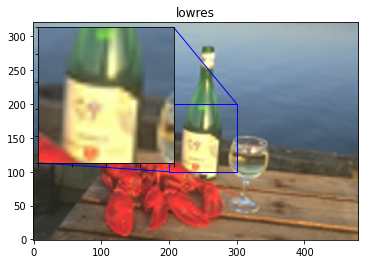

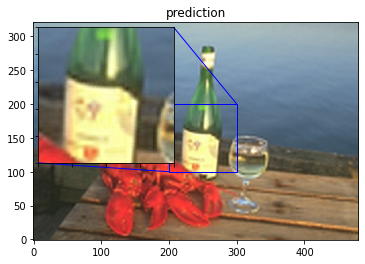

Out shape: (1, 321, 480, 1)
PSNR of low resolution image and high resolution image is 24.9783
PSNR of predict and high resolution is 25.4692


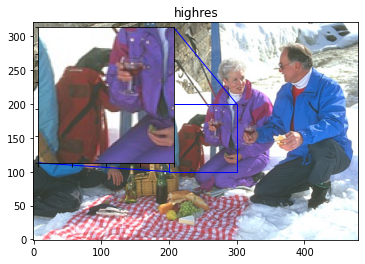

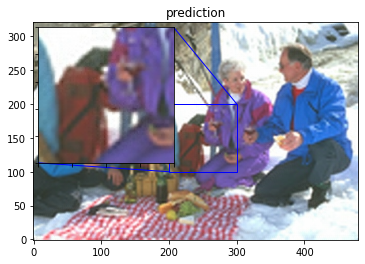

Out shape: (1, 480, 321, 1)
PSNR of low resolution image and high resolution image is 27.7724
PSNR of predict and high resolution is 28.0862


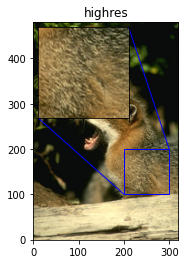

Out shape: (1, 321, 480, 1)
PSNR of low resolution image and high resolution image is 28.0314
PSNR of predict and high resolution is 28.1614


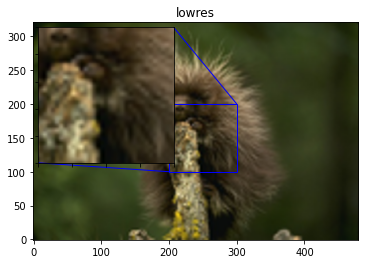

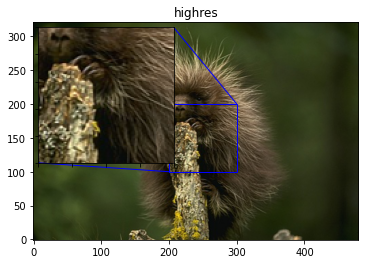

Out shape: (1, 321, 480, 1)
PSNR of low resolution image and high resolution image is 25.7630
PSNR of predict and high resolution is 26.0568


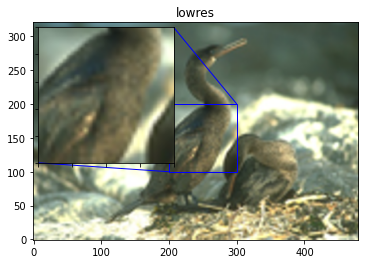

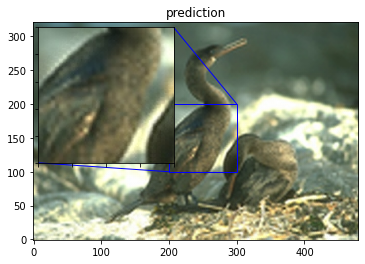

Out shape: (1, 321, 480, 1)
PSNR of low resolution image and high resolution image is 25.7874
PSNR of predict and high resolution is 26.1502


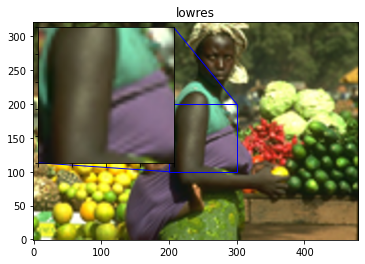

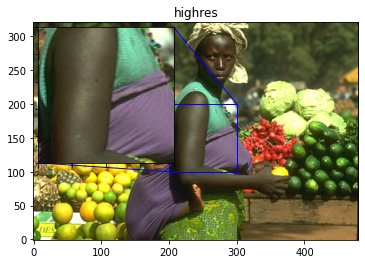

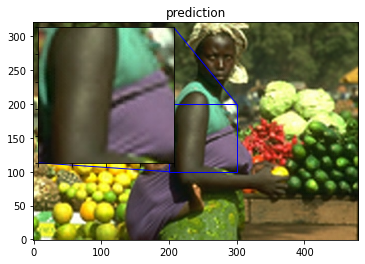

Out shape: (1, 321, 480, 1)
PSNR of low resolution image and high resolution image is 26.2512
PSNR of predict and high resolution is 26.7616


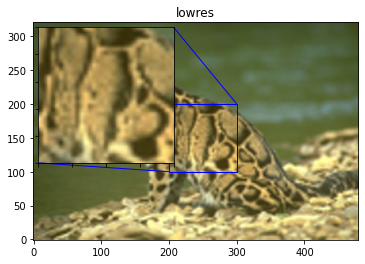

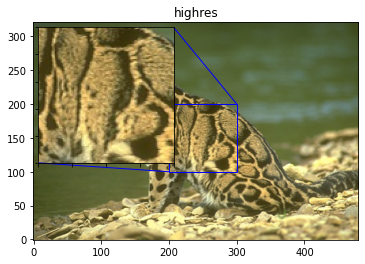

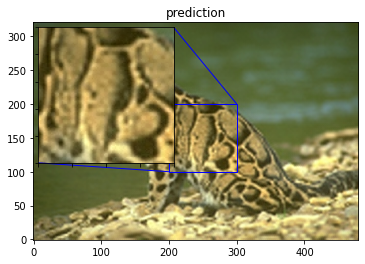

Out shape: (1, 321, 480, 1)
PSNR of low resolution image and high resolution image is 23.3820
PSNR of predict and high resolution is 24.0446


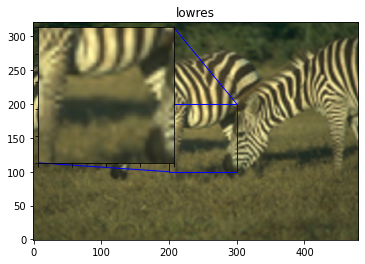

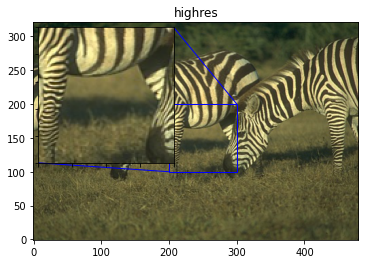

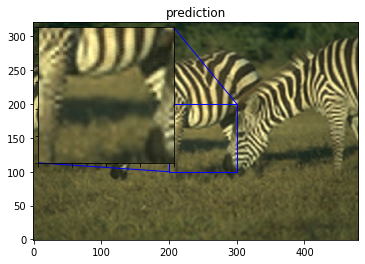

Out shape: (1, 321, 480, 1)
PSNR of low resolution image and high resolution image is 29.8914
PSNR of predict and high resolution is 29.9533


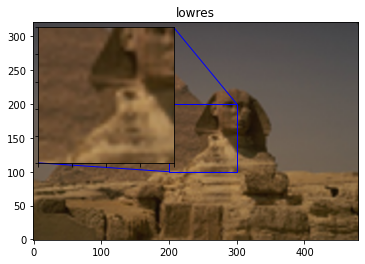

Out shape: (1, 480, 321, 1)
PSNR of low resolution image and high resolution image is 25.1712
PSNR of predict and high resolution is 25.4798


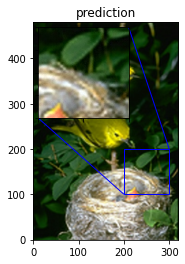

Avg. PSNR of lowres images is 26.6879
Avg. PSNR of reconstructions is 27.0216


In [18]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print("PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr)
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))